# **Network Measurement Homework 1**

### Installing required packages and importing libraries

In [ ]:
! pip install pythonping
! pip install numpy matplotlib

In [62]:
import pandas as pd # To read & write csv files and use powerful dataframe features
import socket # To get IP addresses of hosts

# To define get_information() function
import urllib.request # To open url of http://ip-api.com/json/
import json # To parse the result of the request
import time # To define a random waiting time to avoid "Too many requests" error
import random #  To define a random waiting time to avoid "Too many requests" error

from pythonping import ping # For RTT measurement
from geopy.distance import geodesic #For distance calculation
from matplotlib import pyplot as plt # To plot
import numpy as np # To use polyfit and other calculations



### Reading Data & Pre-processing

The hostnames.csv includes the all host names at https://www.debian.org/mirror/list. The csv file was created by using Microsoft Excel HTML import tool. The dataset includes 335 host names from many countries.

In [5]:
# This is the path for host names
path_prefix = 'drive/MyDrive/NMDA/HW1/'
file_path = path_prefix + 'data/hostnames.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
print(df)

                               Host Name
0                   debian.unnoba.edu.ar
1                      ftp.am.debian.org
2                       mirrors.asnet.am
3                      ftp.au.debian.org
4    debian.mirror.digitalpacific.com.au
..                                   ...
330          plug-mirror.rcac.purdue.edu
331                   repo.ialab.dsu.edu
332              debian.repo.cure.edu.uy
333                mirror.bizflycloud.vn
334                      mirrors.bkns.vn

[335 rows x 1 columns]


In this part, socket is used to get the IP addresses of the hosts. The IP addresses were found because the geographic location of the hosts can be queried by their IP addresses. No error message were received. All the IP addresses were found successfully Running next cell can be skipped and loading the output can be read from "hostname_ip.csv"

In [ ]:
# Defining a function to get IP address based on hostname using socket
def get_ip_address(hostname):
    try:
        ip_address = socket.gethostbyname(hostname)
        return ip_address
    except socket.error as e:
        print(f"Error: {e}")
        return 'Unknown'

# Creating a new column 'ip_addr' by applying the 'get_ip_address' function to the 'hostnames' column
df['IP Address'] = df['Host Name'].apply(get_ip_address)

# Displaying the updated DataFrame
print(df)

                               Host Name       IP Address
0                   debian.unnoba.edu.ar     200.14.116.3
1                      ftp.am.debian.org   93.187.162.100
2                       mirrors.asnet.am   93.187.162.100
3                      ftp.au.debian.org    103.84.224.37
4    debian.mirror.digitalpacific.com.au     101.0.120.90
..                                   ...              ...
330          plug-mirror.rcac.purdue.edu  128.211.151.252
331                   repo.ialab.dsu.edu  138.247.115.248
332              debian.repo.cure.edu.uy     164.73.233.2
333                mirror.bizflycloud.vn  103.107.181.186
334                      mirrors.bkns.vn   103.121.88.254

[335 rows x 2 columns]


In [6]:
# This cell is to skip running previous cell
# df.to_csv(path_prefix + 'data/hostname_ip.csv', index=False)
df = pd.read_csv(path_prefix + 'data/hostname_ip.csv')

In this part, IP addresses were used to query geographic information about hosts. The latitude and longitude were captured to calculate distances. The country and city information were kept for concluding additional information.

ip-api gives "Too many requests" error when the all IP addresses are queried. Therefore, a random waiting time is added to function, which makes long waiting time, however, it is needed to use ip-api

In [8]:
# Define a function to get IP address based on hostname using socket
def get_information(ip):
        delay =  random.randint(1, 5)
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        time.sleep(delay)
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']


        return country, city, latitude, longitude

Avoiding to run the next cell is suggested because it approximately lasts 16 minutes. The output csv file can be loaded from "hosts_with_location.csv" in the next cell

In [ ]:
df[['Country', 'City', 'Latitude', 'Longitude']] = df['IP Address'].apply(lambda x: pd.Series(get_information(x)))
df.head(10)

,Host Name,IP Address,Country,City,Latitude,Longitude
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397


In [7]:
#df.to_csv(path_prefix + 'data/hosts_with_location.csv', index=False)
df = pd.read_csv(path_prefix + 'data/hosts_with_location.csv')


### Measuring RTT and Calculating Distances

Now the data is ready for measuring RTT and calculating distances. First, We retrieve our information here. Since Google Colab is used, the location of the colab VM may be changed in different runtime sessions. The ping results can be read from "hosts_with_RTT.csv" in the next cell

In [42]:
api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude
# My info is ('35.231.19.59', 'United States', 'North Charleston', 32.8771, -80.013)

('35.237.139.67', 'United States', 'North Charleston', 32.8771, -80.013)

In [43]:
def get_RTT(ip):
  resp = ping(target=ip, count=3)
  return resp.rtt_avg*1000

df['RTT'] = df['IP Address'].apply(get_RTT)
df.head(10)

,Host Name,IP Address,Country,City,Latitude,Longitude,RTT,Distance
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470,136.482231,7728.197555
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,150.812123,10114.653397
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,151.280002,10114.653397
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.516805,15308.794837
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090,196.198781,15308.794837
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060,208.310681,15529.432414
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067,196.331151,15331.791309
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006,201.073827,15309.620241
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.326089,15308.794837
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397,209.381744,14934.806339


To read data that was used to do analysis

In [81]:
#df.to_csv(path_prefix + 'data/hosts_with_RTT.csv', index=False)
df = pd.read_csv(path_prefix+'data/hosts_with_RTT.csv')


In [64]:
# Function to calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).kilometers

# Calculate distances and add a new column to the DataFrame
df['Distance'] = df.apply(lambda row: haversine_distance(my_latitude, my_longitude, row['Latitude'], row['Longitude']), axis=1)
df.head(10)


,Host Name,IP Address,Country,City,Latitude,Longitude,RTT,Distance
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470,136.482231,7728.197555
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,150.812123,10114.653397
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,151.280002,10114.653397
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.516805,15308.794837
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090,196.198781,15308.794837
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060,208.310681,15529.432414
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067,196.331151,15331.791309
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006,201.073827,15309.620241
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.326089,15308.794837
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397,209.381744,14934.806339


In [65]:
# Remove rows with RTT value higher than 1999 because 2000 ms response time means timeout
high_rtt_rows = df[df['RTT'] == 2000]

# Removing the row with timeout
df = df[df['RTT'] < 2000]

print(high_rtt_rows)


Empty DataFrame
Columns: [Host Name, IP Address, Country, City, Latitude, Longitude, RTT, Distance]
Index: []


When we examined

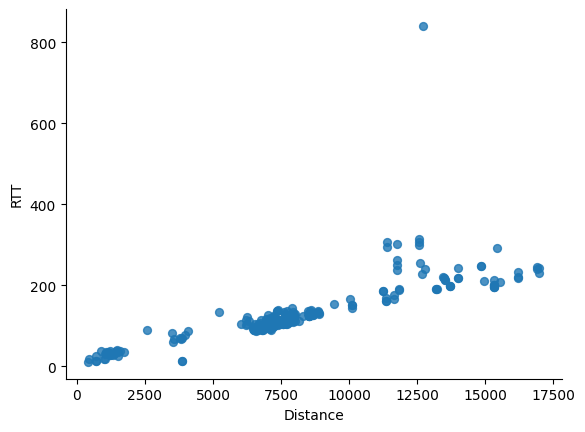

In [66]:
# @title RTT vs Distance

df.plot(kind='scatter', x='Distance', y='RTT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

An anomaly can be observed in the distance range between 11000 and 13000. To examine this, the measurement with distance lower than 130000 and RTT greater 250 ms is selected.

In [67]:
outliers = df[((df['RTT'] >= 250) & (df['Distance']<13000))]

# Sort selected rows by RTT in descending order
sorted_outliers = outliers.sort_values(by='RTT', ascending=False)

# Display the sorted rows
print("Sorted rows with RTT greater than 250 ms although their distance is smaller than 13000 kms (descending order):")
print(sorted_outliers)


Sorted rows with RTT greater than 250 ms although their distance is smaller than 13000 kms (descending order):
                           Host Name       IP Address Country      City  \
46                   mirrors.163.com     60.191.80.15   China  Hangzhou   
50                mirror.sjtu.edu.cn   111.186.58.212   China  Shanghai   
153  debian.mirror.liquidtelecom.com     197.155.77.1   Kenya   Nairobi   
49                mirrors.jlu.edu.cn      59.72.66.10   China  Shenyang   
45               mirror.nyist.edu.cn     59.69.128.21   China   Beijing   
44                 mirror.nju.edu.cn     210.28.130.3   China   Nanjing   
51            mirrors.neusoft.edu.cn   219.216.128.25   China  Shenyang   
52      mirrors.tuna.tsinghua.edu.cn     101.6.15.130   China   Haidian   
53               mirrors.ustc.edu.cn  202.141.176.110   China     Hefei   
47               mirrors.bfsu.edu.cn    39.155.141.16   China   Beijing   

     Latitude  Longitude         RTT      Distance  
46    30.2

The most of the outliers are from China. The reason could be the strict restrictions of internet in China. Therefore, the ping packet could spend time in additional packet inspection nodes.

In [68]:
df.describe()

,Latitude,Longitude,RTT,Distance
count,291.000000,291.000000,291.000000,291.000000
mean,37.848015,18.388476,126.015920,7964.415807
std,24.757056,63.869074,71.182207,3447.151040
min,-45.882500,-123.192400,10.478712,418.596227
25%,38.830850,2.217965,98.223528,6868.078204
50%,47.132800,12.373100,110.449726,7388.148602
75%,51.153000,28.135600,132.710684,8576.060307
max,64.151400,174.793200,840.364189,16972.018893


In [69]:
# Find the index of the row with the minimum RTT
min_rtt_index = df['RTT'].idxmin()
# Extract the row with the minimum RTT
row_with_min_rtt = df.loc[min_rtt_index]

# Find the index of the row with the minimum Distance
min_distance_index = df['Distance'].idxmin()
# Extract the row with the minimum Distance
row_with_min_distance = df.loc[min_distance_index]

# Find the index of the row with the maximum RTT
max_rtt_index = df['RTT'].idxmax()
# Extract the row with the maximum RTT
row_with_max_rtt = df.loc[max_rtt_index]

# Find the index of the row with the maximum Distance
max_distance_index = df['Distance'].idxmax()
# Extract the row with the maximum Distance
row_with_max_distance = df.loc[max_distance_index]

# Print the results
print("Row with minimum RTT:")
print(row_with_min_rtt)

print("\nRow with minimum Distance:")
print(row_with_min_distance)

print("\nRow with maximum RTT:")
print(row_with_max_rtt)

print("\nRow with maximum Distance:")
print(row_with_max_distance)


Row with minimum RTT:
Host Name     atl.mirrors.clouvider.net
IP Address                92.119.16.152
Country                   United States
City                            Atlanta
Latitude                        33.7485
Longitude                      -84.3871
RTT                           10.478712
Distance                     418.596227
Name: 264, dtype: object

Row with minimum Distance:
Host Name     atl.mirrors.clouvider.net
IP Address                92.119.16.152
Country                   United States
City                            Atlanta
Latitude                        33.7485
Longitude                      -84.3871
RTT                           10.478712
Distance                     418.596227
Name: 264, dtype: object

Row with maximum RTT:
Host Name     mirrors.163.com
IP Address       60.191.80.15
Country                 China
City                 Hangzhou
Latitude              30.2994
Longitude            120.1612
RTT                840.364189
Distance         12697.9398

### Approximation for RTT

Before starting to fit a linear function, one row is removed, which was extremely outlier.

In [77]:
print("The removed row:")
print(df.iloc[46])

The removed row:
Host Name     mirrors.163.com
IP Address       60.191.80.15
Country                 China
City                 Hangzhou
Latitude              30.2994
Longitude            120.1612
RTT                840.364189
Distance         12697.939801
Name: 46, dtype: object


In [82]:
# Removing the row with row number 46 from the original DataFrame
df.drop(46, inplace=True)


Average RTT (ms) per km: 0.015255768001473314


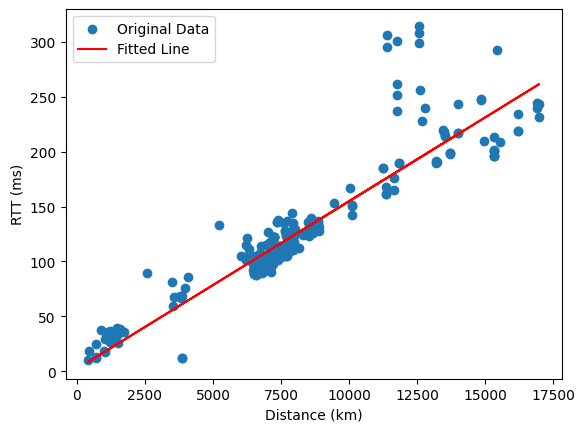

In [83]:
# Fitting a linear function using numpy.polyfit
coefficients = np.polyfit(df['Distance'], df['RTT'], deg=1)

# Extracting the slope and intercept from the coefficients
slope, intercept = coefficients

# Printing the slope (average RTT per km)
print("Average RTT (ms) per km:", slope)

# Ploting the original data and the fitted linear function (optional)
plt.scatter(df['Distance'], df['RTT'], label='Original Data')
plt.plot(df['Distance'], slope * df['Distance'] + intercept, color='red', label='Fitted Line')
plt.xlabel('Distance (km)')
plt.ylabel('RTT (ms)')
plt.legend()
plt.show()


### Analysis & Conclusion